In [1]:
import time
print(time.ctime())

Thu Sep  1 10:55:44 2022


<sub>Bei diesem IPython-Notebook handelt es sich um eine Beispiel-Rechnung als Ergänzung zur Dissertationsschrift von C. Knoll. Allgemeine Hinweise zu den Beispielen sind in der [readme.md-Datei des entsprechenden Repositoriums](https://github.com/cknoll/beispiele/blob/master/readme.md) zu finden.</sub>

---

**Betrachtetes System:** Linearisiertes Modell des abgebildeten ebenen einrädriges Fahrzeug unter dem Einfluss der Schwerkraft.<br>

<img src="files/images/unicycle.png">

**Betrachtete Fragen**:
* Herleitung der Modellgleichungen
* Linearisierung um eine Ruhelage
* Bestimmung eines konfigurationsflachen Ausgangs (des linearisierten Modells)

[//]: # (custom_config_start)
$$
\newcommand{\d}{\mathrm{d}}
\newcommand{\col}{\mathrm{col}}
\newcommand{\bs}{\boldsymbol}
\newcommand{\tt}{\boldsymbol{\theta}}
\newcommand{\Ddt}{\left(\tfrac{d}{dt}\right)}
\newcommand{\ddt}{\tfrac{d}{dt}}
$$
[//]: # (custom_config_end)


In [2]:
%load_ext ipydex.displaytools

import sympy as sp
from sympy import sin, cos, pi, Matrix
from sympy.interactive import printing
import pycartan as pc # perspektivisch: pycartan
import symbtools as st
import symbtools.modeltools as mt
from symbtools import symbs_to_func

printing.init_printing()

In [3]:
np = 1
nq = 2
n = np + nq
pp = st.symb_vector("p1:{0}".format(np+1))
qq = st.symb_vector("q1:{0}".format(nq+1))

ttheta = st.row_stack(pp, qq) ##T
tthetad = st.time_deriv(ttheta, ttheta) ##T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##T

st.make_global(ttheta, tthetad)

---

---

---

In [4]:
params = sp.symbols('l0, l1, s1, s2, J0, J1, J2, m0, m1, m2, g')
param_values = dict(m0=1, m1=1, m2=1, l0=1, g=10, l1=2, s1=1, s2=1, J0=0.1, J1=0.1, J2=0.1)

ttau = sp.symbols("tau1, tau2")
st.make_global(params, ttau)

In [5]:
# Geometrie: (Einheitsvektoren)
ex = Matrix([1,0])
ey = Matrix([0,1])

# Mittelpunkt (und Schwerpunkt) des Rades
M1 = Matrix([-l0*p1, l0]) 

# Schwerpunkte der Körper K2, K3
S2 = M1 + mt.Rz(p1+q1)*ey*s1
S3 = M1 + mt.Rz(p1+q1)*ey*l1+mt.Rz(p1+q1+q2)*ey*s2

M1d = st.time_deriv(M1, ttheta)
S2d = st.time_deriv(S2, ttheta)
S3d = st.time_deriv(S3, ttheta)

In [6]:
# Energie
T_rot = ( J0*pdot1**2 + J1*(qdot1+pdot1)**2 + J2*(qdot2 + qdot1 + pdot1)**2 )/2
T_trans = ( m0*M1d.T*M1d  +  m1*S2d.T*S2d  +  m2*S3d.T*S3d )/2

T = T_rot + T_trans[0]

V = m1*g*S2[1] + m2*g*S3[1]

In [7]:
%%time
mod = mt.generate_symbolic_model(T, V, sp.Matrix(ttheta), [0, tau1, tau2])

CPU times: user 1min 59s, sys: 99.9 ms, total: 1min 59s
Wall time: 1min 59s


Nachweis, dass $\bs \theta \equiv (p_1^\circ, -p_1^\circ, 0)^T$ eine Ruhelage für $\bs \tau \equiv 0$ ist.

In [8]:
p1eql = sp.Symbol('p_1^\circ')
eqlb = [(p1, p1eql), (q1, -p1eql)] + st.zip0(ttheta[2:], tthetad, tthetadd, ttau) ##:

---

In [9]:
mod.eqns.subs(eqlb) ##T

---

⇒ Bewegungsgleichungen sind erfüllt.
---

Implizites Modell $\bs F(\tt)$ aufstellen (nur die ersten $n_{\bs p}$ Gleichungen berücksichtigen).


In [10]:
FF = mod.eqns[:np, 0]

In [11]:
P0 = FF.jacobian(ttheta).subs(eqlb) ##:
P1 = FF.jacobian(tthetad).subs(eqlb) ##:
P2 = FF.jacobian(tthetadd).subs(eqlb).smplf ##:

---

---

---

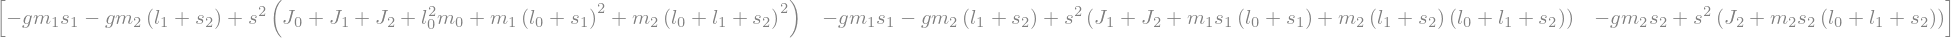

---

---

In [12]:
s = sp.Symbol('s')
PFa = P0 + P1*s + P2*s**2##:

# für bessere Übersicht: Parameterwerte einsetzen
PF = PFa.subs(param_values) ##:

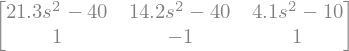

---

In [13]:
# 1. Ansatz-Zeile für die unimodulare Ergänzung
Q_row1 = sp.Matrix([1, -1, 1]).T
PQ_1 = st.row_stack(PF, Q_row1) ##:

Hautus Kriterium überprüfen: Für alle $s \in \mathbb{C}$ muss es mindestens einen nichtverschwindenden Minor geben.

In [14]:
st.all_k_minors(PQ_1, 2)

⇒ Hautus-Kriterium erfüllt.

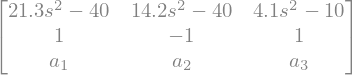

---

In [15]:
# 2. Ansatz-Zeile für die unimodulare Ergänzung
Q_row2 = st.symb_vector('a1, a2, a3').T
PQ = st.row_stack(PF, Q_row1, Q_row2) ##:

In [16]:
d = sp.Symbol('d')

In [17]:
det = PQ.det()  ##:
coeffs = st.poly_coeffs(det- d, s)##:
sol = sp.solve(coeffs, Q_row2)##:

---

---

---

In [18]:
st.clean_numbers(Q_row2.subs(sol)) ##

Q_row2.subs(sol).subs([(d, -31.1), ('a3', 0)]) ##

Mit $d=-31.1$ erhält man zwei überschaubare Dezimalbrüche. Der Parameter $a_3$  kann beliebig gewählt werden und wird deshalb hier auf Null gesetzt.

---

Andere Wahl der ersten Ergänzungszeile (vgl. auch [Knoll, Röbenack, 2015]: ("Konfigurationsflachheit linearer mechanischer Systeme")):


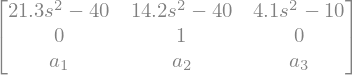

In [19]:
PQ[1,:] = sp.Matrix([0,  1, 0]).T
PQ

In [20]:
det = PQ.det()  ##:
coeffs = st.poly_coeffs(det- d, s)##:
sol = sp.solve(coeffs, Q_row2)##:
st.clean_numbers(Q_row2.subs(sol)) ##

---

---

---

In [21]:
st.clean_numbers(Q_row2.subs(sol)).subs([(d, 4.9), ('a2', 0)])